In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

# analog data assimilation
import sys
sys.path.insert(0, '/home/ptandeo/Dropbox/Documents/Codes/Python/AnDA_CME')
from AnDA_codes.AnDA_generate_data import AnDA_generate_data
from AnDA_codes.AnDA_analog_forecasting import AnDA_analog_forecasting
from AnDA_codes.AnDA_model_forecasting import AnDA_model_forecasting
from AnDA_codes.AnDA_data_assimilation import AnDA_data_assimilation
from AnDA_codes.AnDA_stat_functions import AnDA_RMSE

Populating the interactive namespace from numpy and matplotlib


In [2]:
F_values = array([6,7,9,10]) # F values of the bad L-96 models
nb_analogs = 50 # number of analogs
nb_dt = 4 # number of dt for the forecast (nb_dt x 0.05 in L96 times)
nb_Ne = 500 # number of ensembles
K = 200 # maximum number of times to compute CME
N_iter = 10 # number of independant observation sets to get confidence intervals
variance_obs = 1 # variance of the observations

In [3]:
def mooving_average(x, N):
    out = np.zeros_like(x, dtype=np.float64)
    dim_len = x.shape[0]
    for i in range(dim_len):
        if N%2 == 0:
            a, b = i - (N-1)//2, i + (N-1)//2 + 2
        else:
            a, b = i - (N-1)//2, i + (N-1)//2 + 1

        #cap indices to min and max indices
        a = max(0, a)
        b = min(dim_len, b)
        out[i] = np.mean(x[a:b])
    return out

def model_evidence(ll_good, ll_bad, K, yo):
    out = np.sum((mooving_average(ll_good-ll_bad,K)>0)/len(yo.time)*100)
    return out

In [4]:
# parameters
class GD:
    model = 'Lorenz_96'
    class parameters:
        F = 8
        J = 40
    dt_integration = 0.05 # integration time
    dt_states = nb_dt # number of integration times between consecutive states (for xt and catalog)
    dt_obs = nb_dt # number of integration times between consecutive observations (for yo)
    var_obs = [17,18,19,20,21] # indices of the observed variables
    nb_loop_train = 1000*nb_dt # size of the catalog
    nb_loop_test = 500*nb_dt # size of the true state and noisy observations
    sigma2_catalog = 0.001 # variance of the model error to generate the catalog   
    sigma2_obs = variance_obs # variance of the observation error to generate observations    
# run the data generation
catalog_good, xt, yo = AnDA_generate_data(GD)

# keep only a subset of variables
catalog_good.analogs = catalog_good.analogs[:,17:22]
catalog_good.successors = catalog_good.successors[:,17:22]
yo.values = yo.values[:,17:22]
n = catalog_good.analogs.shape[1]
global_analog_matrix=np.ones([n,n])

# parameters of the analog forecasting method
class AF:
    k = nb_analogs # number of analogs
    neighborhood = global_analog_matrix
    catalog = catalog_good # catalog with analogs and successors
    regression = 'local_linear' # chosen regression ('locally_constant', 'increment', 'local_linear')
    sampling = 'gaussian' # chosen sampler ('gaussian', 'multinomial')
    kernel = 'tricube'
    initialized=False
# parameters of the filtering method
class DA:
    method = 'AnEnKF' # chosen method ('AnEnKF', 'AnEnKS', 'AnPF')
    N = nb_Ne # number of members (AnEnKF/AnEnKS) or particles (AnPF)
    xb = xt.values[0,17:22]; B = 0.1*np.eye(n)
    H = np.eye(n)
    R = GD.sigma2_obs*np.eye(n)
    @staticmethod
    def m(x):
        return AnDA_analog_forecasting(x,AF)
# run the analog data assimilation
x_hat_analog_good = AnDA_data_assimilation(yo, DA)

100%|██████████| 10000/10000 [1:06:22<00:00,  2.51it/s]


In [5]:
class yo_iter:
    values = [];
    time = [];
tab_ME_AnDA = zeros([N_iter,len(F_values),K])
for i_iter in range(N_iter):
    p_iter = int(np.shape(yo.values)[0]/N_iter)
    print([i_iter*p_iter, (i_iter+1)*p_iter])
    yo_iter.time = yo.time[i_iter*p_iter:(i_iter+1)*p_iter]
    yo_iter.values = yo.values[i_iter*p_iter:(i_iter+1)*p_iter,:]
    for i_F in range(len(F_values)):
        print(F_values[i_F])
        # parameters
        class GD:
            model = 'Lorenz_96'
            class parameters:
                F = F_values[i_F]
                J = 40
            dt_integration = 0.05 # integration time
            dt_states = nb_dt # number of integration times between consecutive states (for xt and catalog)
            dt_obs = nb_dt # number of integration times between consecutive observations (for yo)
            var_obs = [17,18,19,20,21] # indices of the observed variables
            nb_loop_train = 1000*nb_dt # size of the catalog
            nb_loop_test = 1 # size of the true state and noisy observations
            sigma2_catalog = 0.001 # variance of the model error to generate the catalog   
            sigma2_obs = variance_obs # variance of the observation error to generate observations    
        # run the data generation
        catalog_bad, tej1, tej2 = AnDA_generate_data(GD)
        # keep only a subset of variables
        catalog_bad.analogs = catalog_bad.analogs[:,17:22]
        catalog_bad.successors = catalog_bad.successors[:,17:22]
        # parameters of the analog forecasting method
        class AF:
            k = nb_analogs # number of analogs
            neighborhood = global_analog_matrix
            catalog = catalog_bad # catalog with analogs and successors
            regression = 'local_linear' # chosen regression ('locally_constant', 'increment', 'local_linear')
            sampling = 'gaussian' # chosen sampler ('gaussian', 'multinomial')
            kernel = 'tricube'
            initialized=False
        # parameters of the filtering method
        class DA:
            method = 'AnEnKF' # chosen method ('AnEnKF', 'AnEnKS', 'AnPF')
            N = nb_Ne # number of members (AnEnKF/AnEnKS) or particles (AnPF)
            xb = xt.values[i_iter*p_iter,17:22]; B = 0.1*np.eye(n)
            H = np.eye(n)
            R = GD.sigma2_obs*np.eye(n)
            @staticmethod
            def m(x):
                return AnDA_analog_forecasting(x,AF)
        # run the analog data assimilation
        x_hat_analog_bad = AnDA_data_assimilation(yo_iter, DA)
        # compute model evidence
        ME_AnDA = zeros(K)
        for k in range(K):
            ME_AnDA[k] = model_evidence(x_hat_analog_good.loglik_center[i_iter*p_iter:(i_iter+1)*p_iter], x_hat_analog_bad.loglik_center, k, yo_iter)
        # stock results
        tab_ME_AnDA[i_iter,i_F,:] = ME_AnDA

[0, 1000]
6


100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


7


100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


9


100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


10


100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


[1000, 2000]
6


100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


7


100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


9


100%|██████████| 1000/1000 [06:31<00:00,  2.55it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


10


100%|██████████| 1000/1000 [06:38<00:00,  2.51it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


[2000, 3000]
6


100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


7


100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


9


100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


10


100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


[3000, 4000]
6


100%|██████████| 1000/1000 [06:31<00:00,  2.56it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


7


100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


9


100%|██████████| 1000/1000 [06:32<00:00,  2.55it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


10


100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


[4000, 5000]
6


100%|██████████| 1000/1000 [06:28<00:00,  2.58it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


7


100%|██████████| 1000/1000 [06:27<00:00,  2.58it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


9


100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


10


100%|██████████| 1000/1000 [06:40<00:00,  2.50it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


[5000, 6000]
6


100%|██████████| 1000/1000 [06:26<00:00,  2.59it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


7


100%|██████████| 1000/1000 [06:22<00:00,  2.61it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


9


100%|██████████| 1000/1000 [06:28<00:00,  2.58it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


10


100%|██████████| 1000/1000 [06:32<00:00,  2.55it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


[6000, 7000]
6


100%|██████████| 1000/1000 [06:28<00:00,  2.57it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


7


100%|██████████| 1000/1000 [06:20<00:00,  2.63it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


9


100%|██████████| 1000/1000 [06:32<00:00,  2.55it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


10


100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


[7000, 8000]
6


100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


7


100%|██████████| 1000/1000 [06:45<00:00,  2.46it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


9


100%|██████████| 1000/1000 [06:48<00:00,  2.45it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


10


100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


[8000, 9000]
6


100%|██████████| 1000/1000 [06:45<00:00,  2.46it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


7


100%|██████████| 1000/1000 [06:48<00:00,  2.45it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


9


100%|██████████| 1000/1000 [06:52<00:00,  2.42it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


10


100%|██████████| 1000/1000 [06:55<00:00,  2.41it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


[9000, 10000]
6


100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


7


100%|██████████| 1000/1000 [06:43<00:00,  2.48it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


9


100%|██████████| 1000/1000 [06:48<00:00,  2.45it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


10


100%|██████████| 1000/1000 [06:50<00:00,  2.44it/s]
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ptandeo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


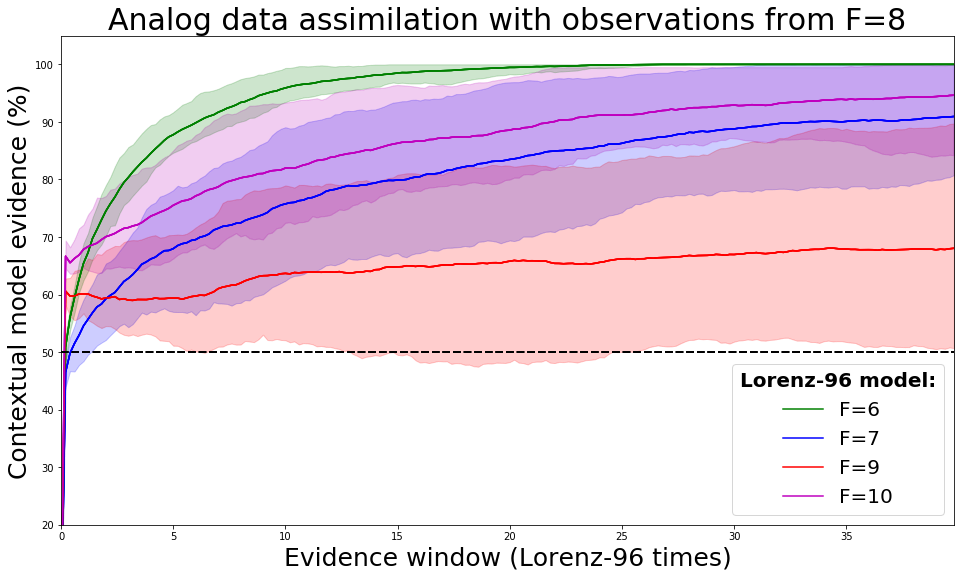

In [6]:
# plot model evidence as a function of evidence window
for i_F in range(len(F_values)):
    line2, = plot(yo.time[0:K], mean(tab_ME_AnDA[:,0,:], 0), 'g')
    line3, = plot(yo.time[0:K], mean(tab_ME_AnDA[:,1,:], 0), 'b')
    line4, = plot(yo.time[0:K], mean(tab_ME_AnDA[:,2,:], 0), 'r')
    line5, = plot(yo.time[0:K], mean(tab_ME_AnDA[:,3,:], 0), 'm')
    fill_between(yo.time[0:K], percentile(tab_ME_AnDA[:,0,:], 5, axis=0), percentile(tab_ME_AnDA[:,0,:], 95, axis=0),
                 color='g', alpha=.05)
    fill_between(yo.time[0:K], percentile(tab_ME_AnDA[:,1,:], 5, axis=0), percentile(tab_ME_AnDA[:,1,:], 95, axis=0),
                 color='b', alpha=.05)
    fill_between(yo.time[0:K], percentile(tab_ME_AnDA[:,2,:], 5, axis=0), percentile(tab_ME_AnDA[:,2,:], 95, axis=0),
                 color='r', alpha=.05)
    fill_between(yo.time[0:K], percentile(tab_ME_AnDA[:,3,:], 5, axis=0), percentile(tab_ME_AnDA[:,3,:], 95, axis=0),
                 color='m', alpha=.05)
                
    xlim([yo.time[0],yo.time[K-1]])
    ylim([20,105])
    leg = legend([line2, line3, line4, line5], ['F=6', 'F=7', 'F=9', 'F=10'], prop={'size': 20}, loc=4)
    leg.set_title('Lorenz-96 model:', prop={'size': 20, 'weight': 'heavy'})
    xlabel('Evidence window (Lorenz-96 times)', size=25)
    ylabel('Contextual model evidence (%)', size=25)
    plot(yo.time[0:K], yo.time[0:K]*0+50, '--k', linewidth=2)
    title('Analog data assimilation with observations from F=8', size=30)
    savefig('model_evidence_F_6to10_CI2020.png', bbox_inches='tight', dpi=400)